# SGLD for Logistic Regression 

---
#### 1. Problem setting
We consider the following Bayesian logistic regression with a Gaussian prior: 

* $\theta \sim \mathcal{N}(0, \sigma^2I)$
* $y_i \underset{i.i.d.}{\sim} \mathcal{B}(\sigma(y_i  x_i^T\theta))$, $\forall i \in \{1, \dots, N\}$


Therefore, the log-posterior of $\theta$ given $x_{1:N}, y_{1:N}$:

\begin{align*}
\log p(\theta|x_{1:N}, y_{1:N}) \propto_+ \sum_{i=1}^N \log\sigma(y_i  x_i^T\theta) -\frac{1}{2\sigma^2} \|\theta\|^2
\end{align*}


Hence the gradient of the log-posterior is:
\begin{align*}
\nabla \log p(\theta|x_{1:N}, y_{1:N}) = \sum_{i=1}^N(1-\sigma(y_i x_i^T\theta)) y_ix_i - \frac{1}{\sigma^2}\theta
\end{align*}


Finally, the Langevin Dyanmics gradient update for a batch size of $n$ is formulated as follows:

\begin{align*}
\theta_{t+1}  &= \theta_{t} + \frac{\epsilon_t}{2}\left[ \nabla \log p(\theta_t) + \frac{N}{n} \sum_{i=1}^n \nabla \log p(y_i|\theta_t, x_i)\right] + \eta_t  \\

&= \theta_{t} + \frac{\epsilon_t}{2}\left[ -\frac{1}{\sigma^2}\theta + \frac{N}{n} \sum_{i=1}^n (1-\sigma(y_i x_i^T\theta))y_i x_i
    \right] + \eta_t
\end{align*}

where $\eta_t \sim \mathcal{N}(0, \epsilon_t I)$, and $\epsilon_t = a(b+t)^{-\gamma}$, with $\gamma \in (0.5, 1]$. 

---
#### 2. Implementation

The code used for implementing SGLD is provided in the file `sgld.py`.

In [1]:
# importing libraries 
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import time
from tqdm import tqdm
from sklearn.datasets import make_classification, make_blobs, make_circles
from scipy.linalg import eigvals
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import pandas as pd
import seaborn as sns 
from sklearn.model_selection import train_test_split


from sgld import *

---
#### 3. Case of linearly separable data

In this first example, we will train the model on a small data set of linearly separable classes using `make_blobs` from sklearn. To make it simple, we choose appropriate values for the centers of the blobs in order not to need to fit a bias term.

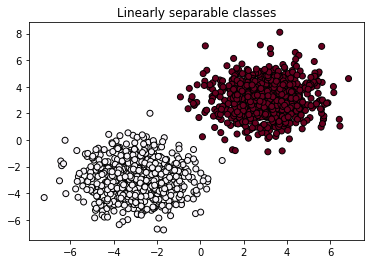

In [2]:
N = 1500 # nb of samples
X, y = make_blobs(n_samples=N, centers=[(-3,-3),(3,3)], cluster_std=1.3, n_features=2, random_state=42)
y = 2 * y - 1

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PuRd', edgecolors='k')
plt.title("Linearly separable classes")
plt.show()

**Training SGLD**

100%|██████████| 5000/5000 [00:01<00:00, 3031.69it/s]


Finished within 1.67 s.


100%|██████████| 5000/5000 [00:02<00:00, 2212.54it/s]


Finished within 2.26 s.


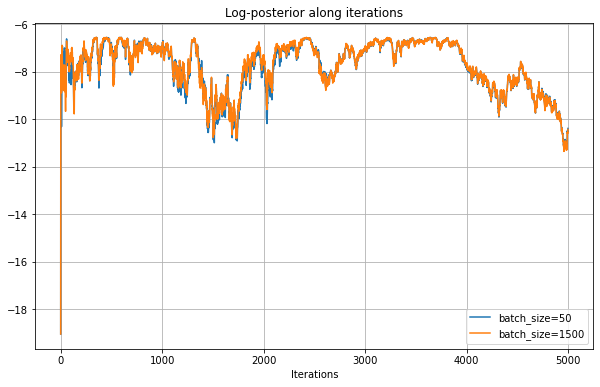

In [3]:
# Parameters 
N, d = X.shape
a, b, gamma= .1, 10, .6 
sigma = 1.          # std. dev. of the prior on theta
n_iter = 5000       # of iterations

# inital theta
np.random.seed(0)
theta_0 = np.ones(X.shape[1])  

# posterior samples
plt.figure(figsize=(10,6)) 
batch_size = 50
samples, _, log_posts, alphas = sgld_logreg(X, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=5000, compute_Vs=True)
plt.plot(log_posts, label=f'batch_size={batch_size}')
batch_size = N
samples, _, log_posts, alphas = sgld_logreg(X, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=5000, compute_Vs=True)
plt.plot(log_posts, label=f'batch_size={batch_size}')

plt.title("Log-posterior along iterations")
plt.xlabel('Iterations')
plt.grid()
plt.legend()
plt.show()

Apparently, we obtain almost the same performance using less training samples. We will therefore set the batch size to $50$.

**Plot of the posterior marginals**

100%|██████████| 5000/5000 [00:01<00:00, 2820.27it/s]


Finished within 1.77 s.


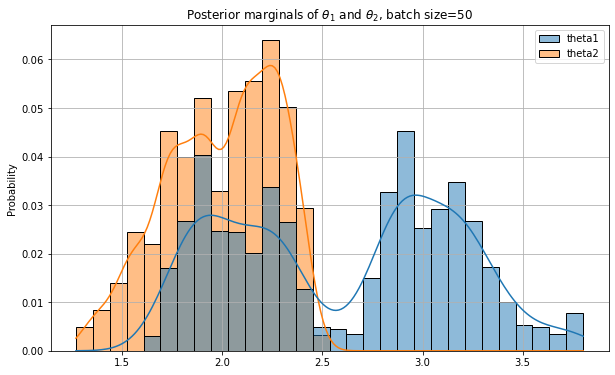

In [13]:
batch_size = 50
samples, _, log_posts, alphas = sgld_logreg(X, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=5000, compute_Vs=True)
plt.figure(figsize=(10,6))

t_burn_in = 3000
post_samples = samples[t_burn_in:]
theta_pd = pd.DataFrame({'theta1':post_samples[:, 0], 'theta2':post_samples[:, 1]})
sns.histplot(data=theta_pd, kde=True, bins=30, stat='probability')
plt.title(f'Posterior marginals of $\\theta_1$ and $\\theta_2$, batch size={batch_size}')
plt.grid()
plt.show()

**Decision boundary**

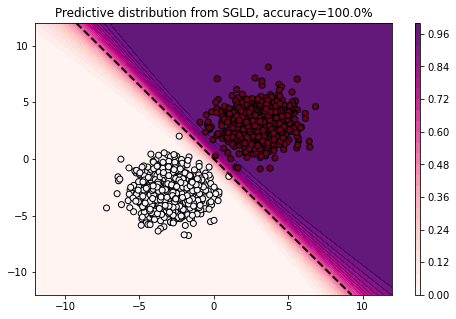

In [24]:
# estimate of the accuracy
weighted_acc = np.mean(alphas[t_burn_in+1].T*compute_accuracy(X, y, post_samples)/(np.sum(alphas[t_burn_in+1])))

# plot of the predictive dist.
x_ = np.linspace(-12, 12, 100)
y_ = np.linspace(-12, 12, 100)
xx, yy = np.meshgrid(x_, y_)
zz = np.array([[xx_, yy_] for (xx_, yy_) in zip(xx.ravel(), yy.ravel())])
ZZ = (make_predictions(zz, post_samples)).reshape(xx.shape)

# contour plot 
plt.figure(figsize=(8,5))
plt.contour(x_, y_, ZZ, colors='k', linestyles='--', linewidths=2, levels=[.5])
cont = plt.contourf(x_, y_, ZZ, 30, cmap='RdPu', vmin=ZZ.min(), vmax=ZZ.max(), alpha=.9)
plt.colorbar(cont, aspect=50)
plt.scatter(X[:,0], X[:,1], c=y, cmap='PuRd', edgecolors='k')
plt.title(f"Predictive distribution from SGLD, accuracy={round(weighted_acc, 3)*100}%");
plt.show()

---
### 4. Case of non-linearly separable data: circle shape classes

In this example, we will train the model on a small data set of non-linearly separable classes with a circle shape using `make_circles` from sklearn.

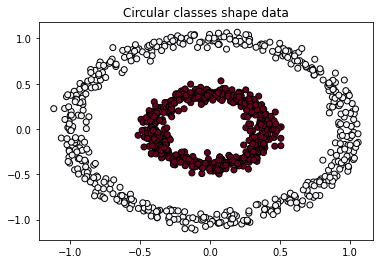

In [25]:
N = 1000 # nb of samples
X, y = make_circles(n_samples=N, factor=.4, noise=.05, random_state=42)
y = 2 * y - 1

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PuRd', edgecolors='k')
plt.title("Circular classes shape data")
plt.show()

In this case, it is important to tranform the data to a high-dimensional feature space. For this, we can use a polynomial of degree 3 to fit the data.

In [26]:
# transforming features 
poly_feat = PolynomialFeatures(3, include_bias=True)
X_phi = poly_feat.fit_transform(X)

print(f"Nb of new dims : {X_phi.shape[1]}")

Nb of new dims : 10


**Training SGLD**

100%|██████████| 5000/5000 [00:01<00:00, 3375.32it/s]


Finished within 1.48 s.


100%|██████████| 5000/5000 [00:01<00:00, 2527.10it/s]


Finished within 1.98 s.


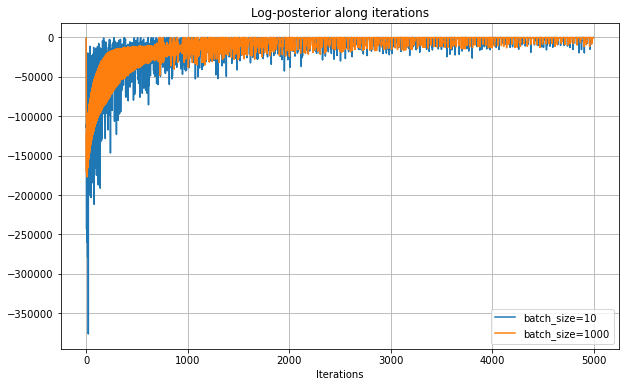

In [27]:
# Parameters 
N, d = X_phi.shape
a, b, gamma= 20, 100, .6 
sigma = 1.          # std. dev. of the prior on theta
n_iter = 5000       # of iterations


# inital theta
theta_0 = np.ones(X_phi.shape[1]) 
plt.figure(figsize=(10,6))

batch_size = 10
samples, _, log_posts, alphas = sgld_logreg(X_phi, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=5000)
plt.plot(log_posts, label=f'batch_size={batch_size}')
batch_size = N
samples, _, log_posts, alphas = sgld_logreg(X_phi, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=5000)
plt.plot(log_posts, label=f'batch_size={batch_size}')


plt.title("Log-posterior along iterations")
plt.xlabel('Iterations')
plt.grid()
plt.legend()
plt.show()

**Comment**: Again, we obtain almost the same performance using less training samples. We will therefore set the batch size to $10$.

**Decision boundary**

100%|██████████| 5000/5000 [00:01<00:00, 3569.74it/s]


Finished within 1.4 s.


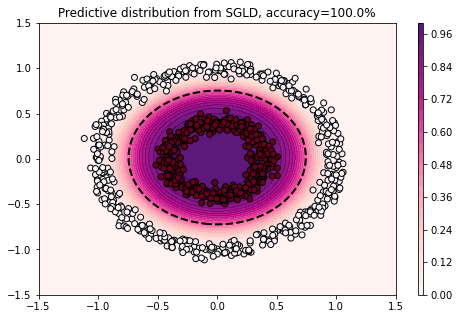

In [35]:
batch_size = 10
a, b, gamma= 1, 20, .6 
samples, _, log_posts, alphas = sgld_logreg(X_phi, y, theta_0, sigma=sigma, gamma=gamma, a=a, b=b, batch_size=batch_size, n_iter=5000)

t_burn_in = 3000   # nb of post. samples to extract
post_samples = samples[t_burn_in:]


# estimate of the accuracy
acc = np.mean(compute_accuracy(X_phi, y, post_samples))

# plot of the predictive dist.
x_ = np.linspace(-1.5, 1.5, 100)
y_ = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x_, y_)
zz = np.array([[xx_, yy_] for (xx_, yy_) in zip(xx.ravel(), yy.ravel())])
zz_phi = poly_feat.transform(zz)
ZZ = (make_predictions(zz_phi, post_samples)).reshape(xx.shape)
ZZ = ZZ.T


# contour plot 
plt.figure(figsize=(8,5))
plt.contour(x_, y_, ZZ, colors='k', linestyles='--', linewidths=2, levels=[.5])
cont = plt.contourf(x_, y_, ZZ, 30, cmap='RdPu', vmin=ZZ.min(), vmax=ZZ.max(), alpha=.9)
plt.colorbar(cont, aspect=50)
plt.scatter(X[:,0], X[:,1], c=y, cmap='PuRd', edgecolors='k')
plt.title(f"Predictive distribution from SGLD, accuracy={round(acc, 3)*100}%");
plt.show()